# Multivariate Standard Cauchy Distribution $f_{\nu}(x) = (1 + ||x||^2)^{-(d+1)/2}$
Including estimation of an unknown probability $p(b) := \mathbb{P}(||X|| > b, X_1 > 0 \mid X \sim \nu)$ for a given bound $b$. Runs around 5 minutes. Warning: IAT computations may take up a lot of memory.

In [1]:
import slice_sampling as ss
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
# Set experiment parameters
d = 100 # dimension, should be > 1
p = 0.25 # ground truth probability for estimation task
itnum = int(1e6) # number of chain iterations
window = int(5e4) # iterations to be shown in radii and log radii trace plots
path_prefix = "../plots/std_Cauchy_"

In [3]:
# compute bound corresponding to p
radius_density = lambda r: np.exp((d-1) * np.log(r) - (d+1)/2 * np.log(1 + r**2)) # (unnormalized) density of radii
C = quad(radius_density, 0, np.inf)[0]
eps = 1e-9 # binary search precision
lo = 1.0
hi = 1e6
while hi - lo > eps:
    mi = (lo + hi) / 2
    if quad(radius_density, mi, np.inf)[0] / C < 2*p:
        hi = mi
    else:
        lo = mi
b = lo
print("Probability {:.2f} corresponds to ball radius {:.4f}.".format(p,b))

Probability 0.25 corresponds to ball radius 14.7721.


/tmp/ipykernel_5961/2651080439.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  if quad(radius_density, mi, np.inf)[0] / C < 2*p:


In [4]:
tde_cnt = 0 # target density evaluation count

In [5]:
def log_density(x):
    global tde_cnt
    tde_cnt += 1
    return -(d+1)/2 * np.log(1 + alg.norm(x)**2)

In [6]:
# Set sampler parameters
x_0 = np.ones(d)
w = d

In [7]:
samples_iid = rnd.chisquare(df=1, size=(itnum+1,1))**(-1/2) * rnd.normal(size=(itnum+1,d))

In [8]:
samples_gpss = ss.gibbsian_polar_ss(log_density, x_0, w, itnum)

In [9]:
tdes_gpss = tde_cnt
tde_cnt = 0

In [10]:
samples_ess = ss.naive_elliptical_ss(log_density, x_0, itnum)

In [11]:
tdes_ess = tde_cnt
tde_cnt = 0

In [12]:
samples_hruss = ss.hit_and_run_uniform_ss(log_density, x_0, w, itnum)

In [13]:
tdes_hruss = tde_cnt
tde_cnt = 0

In [14]:
snames = ["Exact", "GPSS", "HRUSS", "ESS"]
long_snames = ["Exact Sampling", "Gibbsian Polar Slice Sampling", "Hit-and-Run Uniform Slice Sampling", "Elliptical Slice Sampling"]
nsam = len(snames)
samples = [samples_iid, samples_gpss, samples_hruss, samples_ess]
msamples = mcu.get_margs_list(samples, 0)
tdes_per_it = np.array([0.0, tdes_gpss, tdes_hruss, tdes_ess]) / itnum # target density evals per iteration
radii = mcu.get_radii_list(samples)
log_radii = [np.log(rs) for rs in radii]
p_ests = [np.cumsum( (rs > b) * (msams > 0) ) / np.arange(1,itnum+2) for rs, msams in zip(radii, msamples)]
iats = mcu.iat_list(log_radii, maxl=itnum//10) # this maxl may still be too small for ESS / HRUSS
radii_window = [rs[:window] for rs in radii]
log_radii_window = [lrs[:window] for lrs in log_radii]

In [15]:
pd.DataFrame(
    np.array([long_snames, np.round(tdes_per_it, 2), np.round(iats, 2)]).T, 
    columns = ["Sampler", "TDEs/it", "IAT"]
)

,Sampler,TDEs/it,IAT
0,Exact Sampling,0.0,1.01
1,Gibbsian Polar Slice Sampling,6.9,8.59
2,Hit-and-Run Uniform Slice Sampling,8.46,51346.93
3,Elliptical Slice Sampling,5.86,35543.94


In [16]:
def pb_conv_plot(est_list, names, filename, figsize=(4.5,3), dpi=250):
    nsam = len(names)
    default_cycler = plt.rcParams["axes.prop_cycle"]
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0, 0.9, nsam)))
    plt.figure(figsize=figsize, dpi=dpi)
    plt.xlabel("iterations")
    plt.ylabel("probability p(b)")
    plt.xscale("log")
    plt.ylim(0,2*p)
    for ests in est_list:
        plt.plot(range(1,itnum+2), ests)
    plt.plot([0,itnum], [p,p], color="black", linestyle="dashed", zorder=0)
    plt.legend(names, loc="upper left")
    pfs.wrapup(path_prefix + filename + ".png")
    plt.rcParams["axes.prop_cycle"] = default_cycler

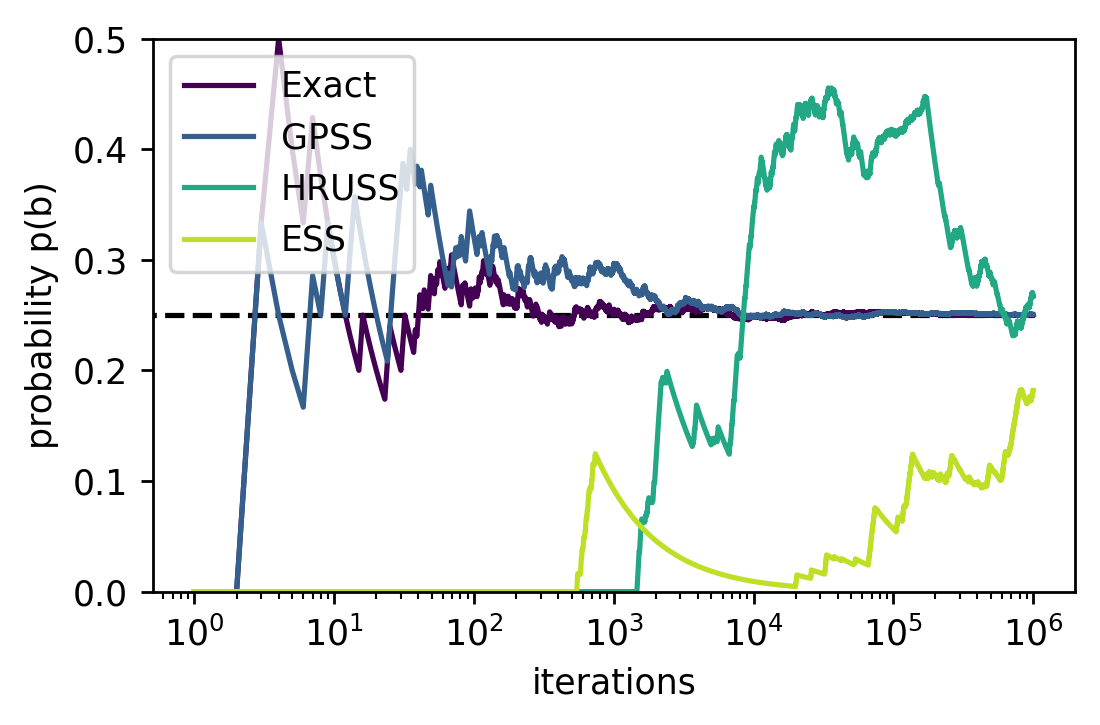

In [17]:
pb_conv_plot(p_ests, snames, "conv_all")

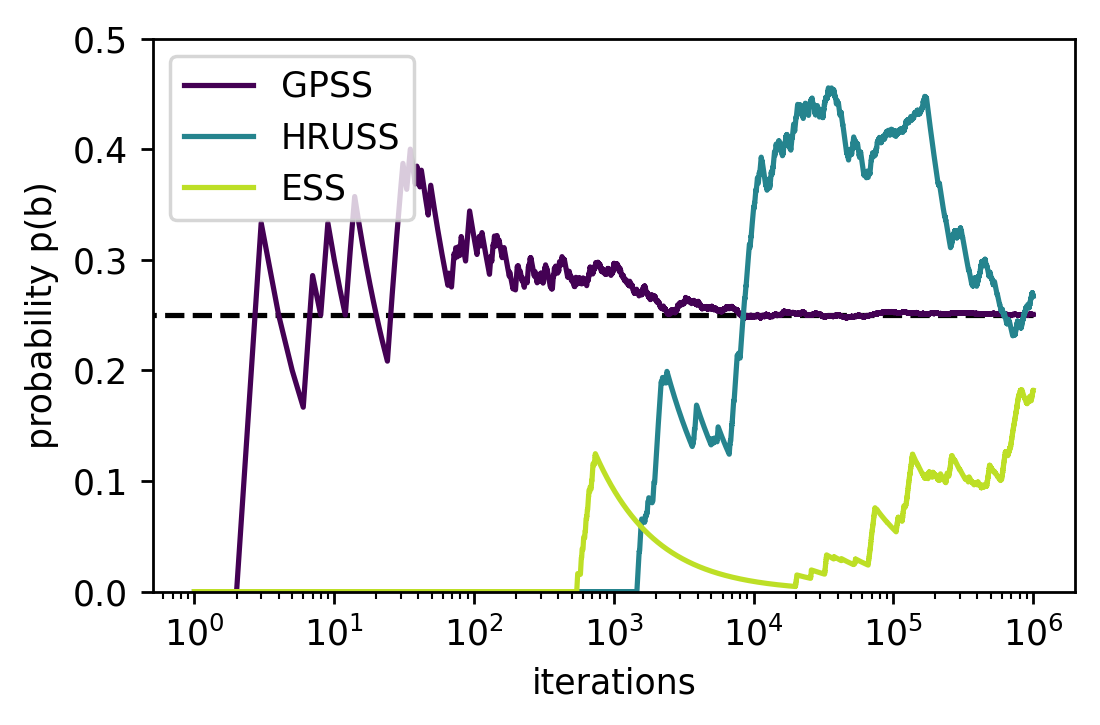

In [18]:
pb_conv_plot(p_ests[1:], snames[1:], "conv_ss")

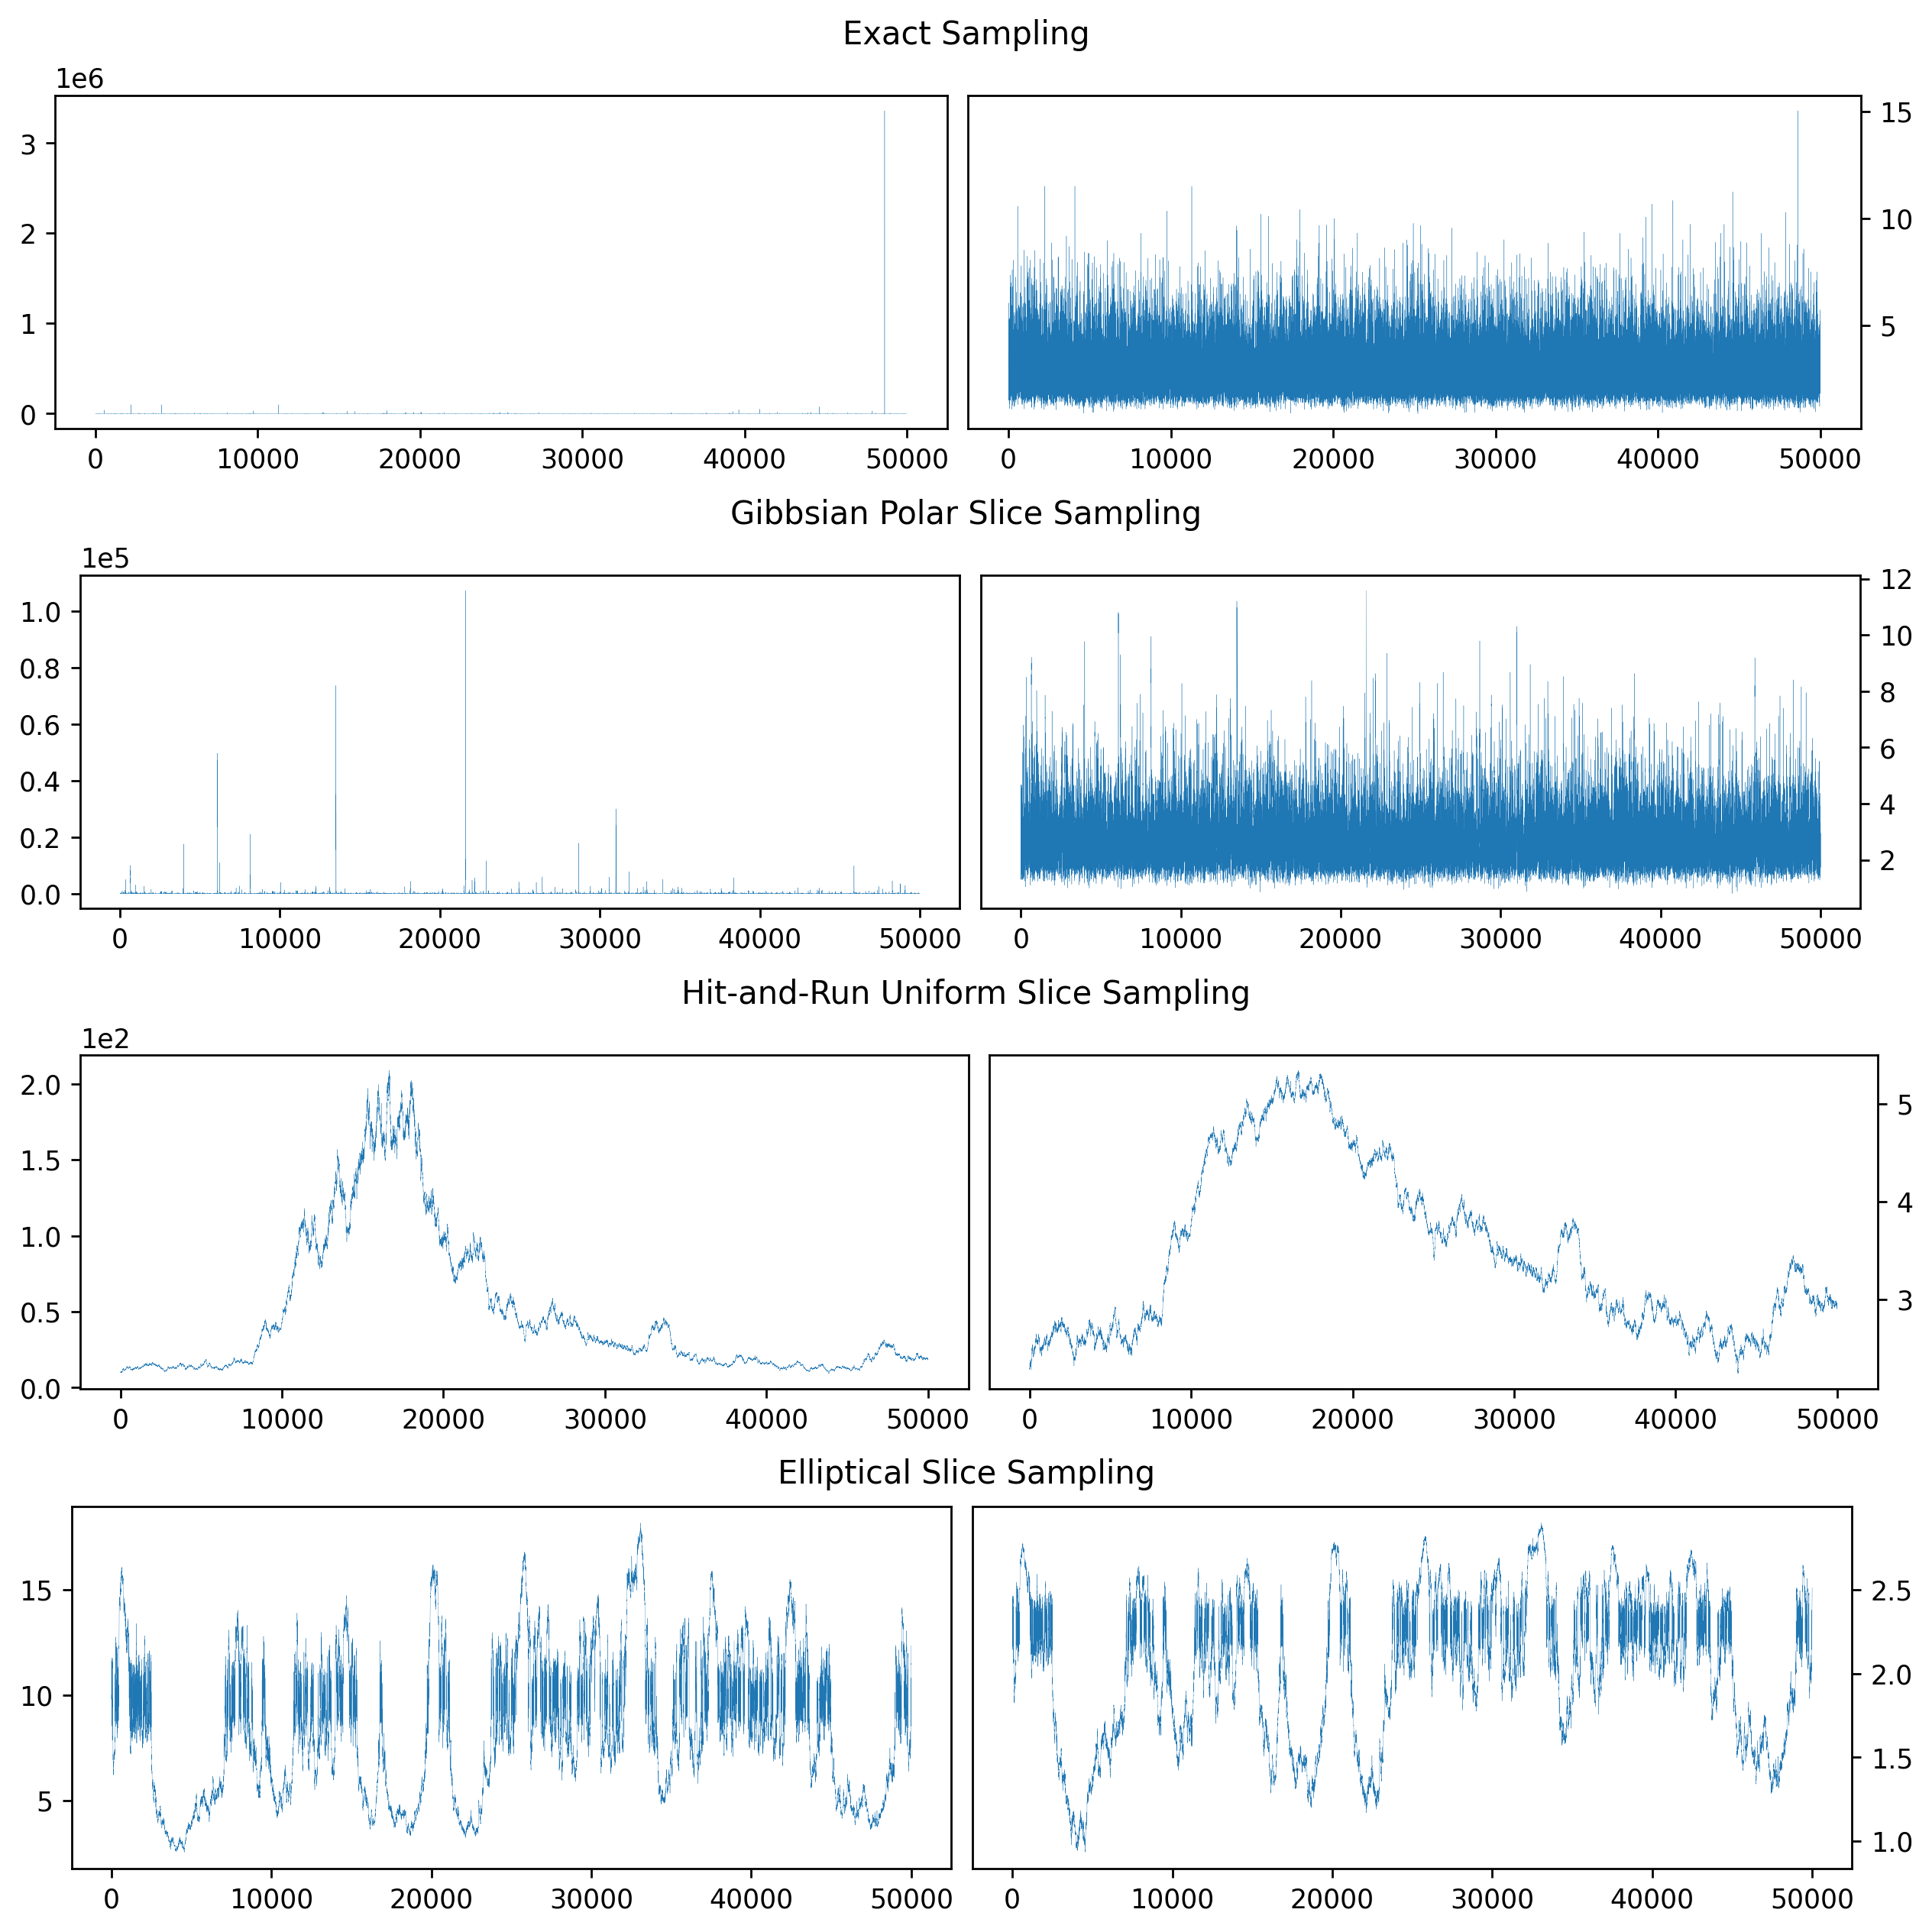

In [19]:
pfs.plot_traces_2_col(
    radii_window, log_radii_window, long_snames, dpi=250, lw1=0.1, lw2=0.1, filepath = path_prefix + "radii.png"
)